In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = pd.read_excel("FTSE100-Jan2005_Oct2024.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by="Date")

In [3]:
df.head()

,Date,Adj Price
4979,2005-01-02,4906.2
4959,2005-01-03,5000.5
4938,2005-01-04,4914.0
4897,2005-01-06,5011.0
4875,2005-01-07,5161.0


In [4]:
df["prev price"] = df["Adj Price"].shift(1)

In [5]:
df.head()

,Date,Adj Price,prev price
4979,2005-01-02,4906.2,NaN
4959,2005-01-03,5000.5,4906.2
4938,2005-01-04,4914.0,5000.5
4897,2005-01-06,5011.0,4914.0
4875,2005-01-07,5161.0,5011.0


In [6]:
df["log returns"] = 100 * np.log(df["Adj Price"] / df["prev price"])
df = df.drop(["prev price"], axis = 1)

In [7]:
df[1:][["Date", "log returns"]].head()

,Date,log returns
4959,2005-01-03,1.903820
4938,2005-01-04,-1.744963
4897,2005-01-06,1.954722
4875,2005-01-07,2.949486
4854,2005-01-08,2.483910


In [8]:
def visualize(df):
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df['Date'], df['log returns'], marker='o', linestyle=' ', color='b', label='log returns')
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Add a horizontal line at 0
    
    # Add titles and labels
    plt.title('Daily Returns Over Time', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('log returns', fontsize=12)
    
    # Improve formatting
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(alpha=0.3)  # Add grid for clarity
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

## Volitility During the whole Dataset

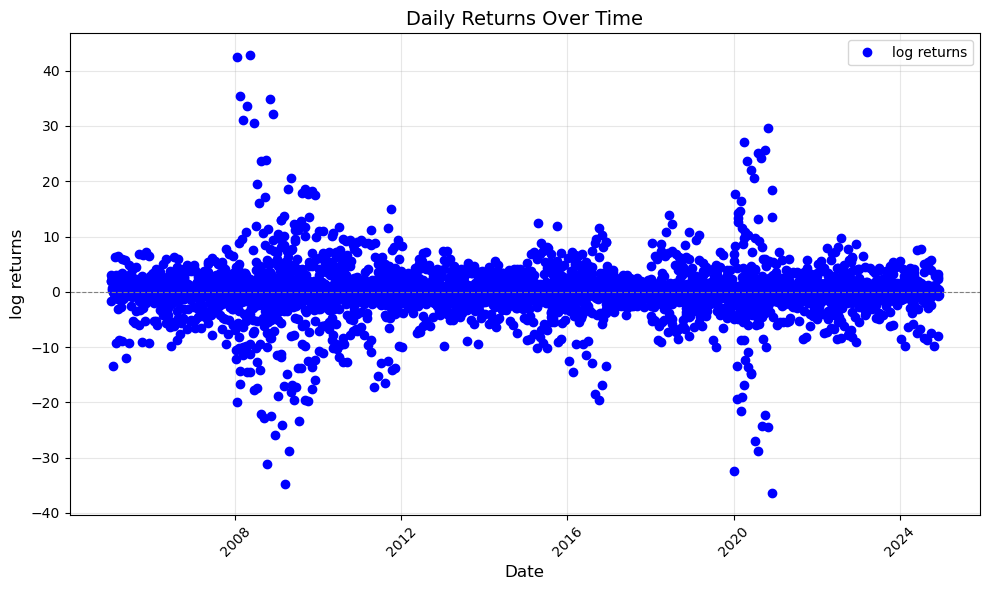

In [9]:
visualize(df)

## Volitility after 2022

In [10]:
time = "2022"
till_date = "2024"
df = df.reset_index()
df = df.drop(columns=["index"])
train_df = df[(df["Date"] > time) & (df["Date"] < till_date)]
test_df = df[(df["Date"] >= till_date)]

In [11]:
print(f"Focused data size: {train_df.size}, total data size: {df.size}")

Focused data size: 1503, total data size: 14964


In [12]:
train_df.head()

,Date,Adj Price,log returns
4283,2022-01-02,7535.78,2.027372
4284,2022-01-03,7330.20,-2.765954
4285,2022-01-04,7537.90,2.794083
4286,2022-01-06,7532.95,-0.065690
4287,2022-01-07,7168.65,-4.956938


/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/3324631239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


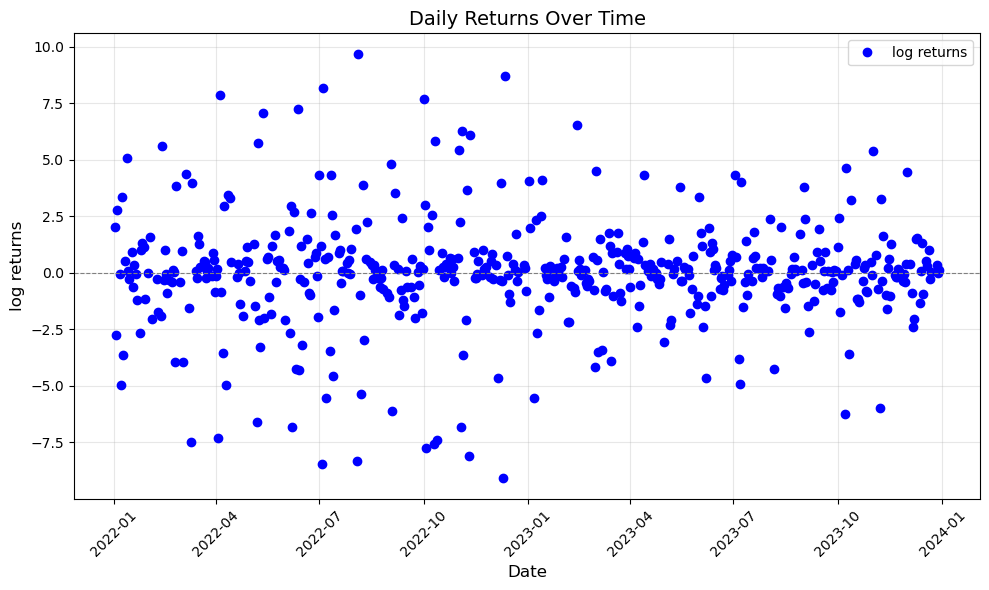

In [48]:
visualize(train_df)

# Check whether the model is stationary or not

## ADF

In [14]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(train_df["log returns"])

# Print the results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpretation
if result[1] < 0.05:
    print("The series is stationary (reject null hypothesis).")
else:
    print("The series is not stationary (fail to reject null hypothesis).")

ADF Statistic: -11.307757186837454
p-value: 1.2609141393846748e-20
Critical Values: {'1%': -3.4436840273842058, '5%': -2.8674204319994674, '10%': -2.5699020441557052}
The series is stationary (reject null hypothesis).


## KPSS

In [15]:
import pandas as pd
from statsmodels.tsa.stattools import kpss


# Perform KPSS Test
def check_stationarity_kpss(series, significance_level=0.05):
    # Perform the KPSS test
    statistic, p_value, lags, critical_values = kpss(series, regression='c', nlags="auto")
    
    # Print the results
    print("KPSS Test Results:")
    print(f"Test Statistic: {statistic}")
    print(f"P-Value: {p_value}")
    print(f"Number of Lags: {lags}")
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"  {key}: {value}")
    
    # Determine stationarity
    if p_value < significance_level:
        print("The series is not stationary (reject null hypothesis).")
    else:
        print("The series is stationary (fail to reject null hypothesis).")

# Call the function with the time series
check_stationarity_kpss(train_df["log returns"])


KPSS Test Results:
Test Statistic: 0.017163065583724248
P-Value: 0.1
Number of Lags: 10
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739
The series is stationary (fail to reject null hypothesis).


/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/4258182724.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  statistic, p_value, lags, critical_values = kpss(series, regression='c', nlags="auto")


## ----------Series is stationary according to ADF and KPSS test----------

In [23]:
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as stats

def residual_analysis(resid_df):
    residuals = resid_df["resid"]
    residSq = resid_df["residSq"]
    
    # Plot residuals over time
    plt.figure(figsize=(10, 4))
    
    
    # Plot autocorrelation of residuals - white noise
    plot_acf(residuals, lags=40, title="Autocorrelation of Residuals")
    plt.show()
    
    # Plot autocorrelation of residuals - Arch effects
    plot_acf(residSq, lags=40, title="Autocorrelation of Residuals square")
    plt.show()
    
    
    # Test for White Noise using Ljung-Box Test
    lb_test = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
    print("Ljung-Box Test Results:")
    print(lb_test)
    
    for lag, p_value in enumerate(lb_test['lb_pvalue'], start=1):
        if p_value > 0.05:
            print(f"Lag {lag}: p-value = {p_value:.4f} -> Fail to reject H₀. Data likely represents white noise.")
        else:
            print(f"Lag {lag}: p-value = {p_value:.4f} -> Reject H₀. Data has significant autocorrelation (not white noise).")
    
    arch_test = het_arch(residuals)
    print("\nEngle's ARCH Test Results:")
    print(f"LM Statistic: {arch_test[0]:.4f}")
    print(f"p-value: {arch_test[1]:.4f}")
    print(f"F-Statistic: {arch_test[2]:.4f}")
    print(f"p-value: {arch_test[3]:.4f}")
    
    lm_stat, lm_p_value, f_stat, f_p_value = arch_test
    if lm_p_value > 0.05:
        print(f"LM Statistic: {lm_stat:.4f}, p-value: {lm_p_value:.4f} -> Fail to reject H₀. No significant ARCH effects (variance is constant).")
    else:
        print(f"LM Statistic: {lm_stat:.4f}, p-value: {lm_p_value:.4f} -> Reject H₀. Significant ARCH effects detected (time-varying volatility).\n\n")


    import statsmodels.api as sm

    sm.qqplot(residuals, line="s")
    plt.title("QQ Plot of Standardized Residuals")
    plt.show()
    from scipy.stats import jarque_bera
    
    stat, p_value = jarque_bera(residuals)
    print(f"\n\nJarque-Bera Test: JB={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print("Residuals appear to be normally distributed (fail to reject H0).")
    else:
        print("Residuals do not appear to be normally distributed (reject H0).")

## ACF and PACF test

<Figure size 1000x500 with 0 Axes>

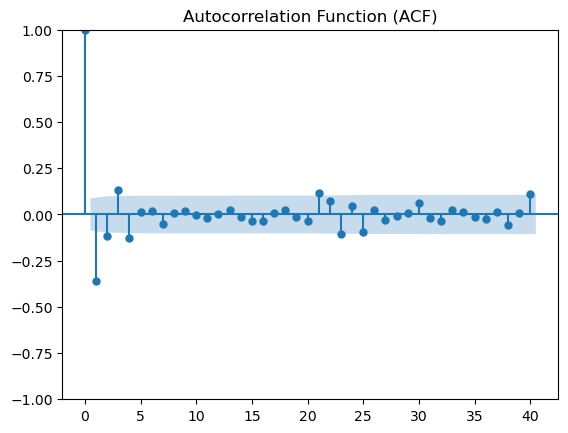

<Figure size 1000x500 with 0 Axes>

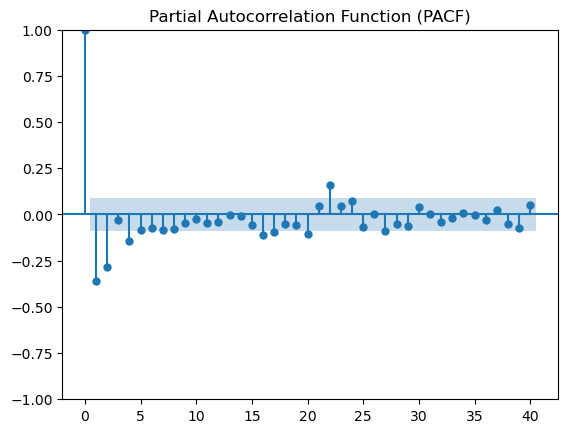

In [17]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Replace 'series' with your time series data (e.g., a Pandas Series)
# Example: series = pd.Series([...])

# ACF Plot
plt.figure(figsize=(10, 5))
plot_acf(train_df["log returns"], lags=40, alpha=0.05)  # 40 lags, 95% confidence interval
plt.title("Autocorrelation Function (ACF)")
plt.show()

# PACF Plot
plt.figure(figsize=(10, 5))
plot_pacf(train_df["log returns"], lags=40, alpha=0.05, method='ywm')  # 40 lags, 95% confidence interval
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()


In [18]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Replace 'series' with your time series data (e.g., a Pandas Series)
# Example: series = pd.Series([...])

# Function to calculate AIC and BIC for different (p, q) values
def calculate_aic_bic(series, max_p, max_q):
    results = []
    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                # Fit ARIMA model (set d=0 for stationary data; adjust if needed)
                model = ARIMA(series, order=(p, 0, q))
                fitted_model = model.fit()
                
                # Append results (p, q, AIC, BIC)
                results.append({
                    'p': p,
                    'q': q,
                    'AIC': fitted_model.aic,
                    'BIC': fitted_model.bic
                })
            except Exception as e:
                # Handle cases where the model fails to fit
                results.append({
                    'p': p,
                    'q': q,
                    'AIC': np.nan,
                    'BIC': np.nan
                })
    
    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Example usage
max_p = 5  # Maximum AR order to test
max_q = 5  # Maximum MA order to test

results_df = calculate_aic_bic(train_df["log returns"], max_p, max_q)



# Restructure the DataFrame for AIC
aic_matrix = results_df.pivot(index='q', columns='p', values='AIC')

# Restructure the DataFrame for BIC
bic_matrix = results_df.pivot(index='q', columns='p', values='BIC')

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  

## AIC Matrix

In [19]:
aic_matrix

p,0,1,2,3,4,5
q,,,,,,
0,2313.079220,2245.646400,2205.743451,2207.262055,2199.041319,2197.590050
1,2199.813066,2190.465364,2189.083002,2179.641788,2179.248605,2180.017727
2,2192.532241,2192.537966,2192.223830,2178.457371,2180.436569,2181.893763
3,2194.496388,2193.753204,2181.733245,2180.420128,2182.320001,2184.070598
4,2180.411297,2181.286485,2181.571991,2182.123586,2184.213233,2182.072098
5,2181.971623,2178.966189,2181.242964,2183.842778,2185.899313,2182.426347


## BIC matrix

In [20]:
bic_matrix

p,0,1,2,3,4,5
q,,,,,,
0,2321.512432,2258.296218,2222.609876,2228.345085,2224.340955,2227.106292
1,2212.462884,2207.331788,2210.166033,2204.941425,2208.764847,2213.750576
2,2209.398665,2213.620997,2217.523466,2207.973613,2214.169418,2219.843218
3,2215.579419,2219.052841,2211.249487,2214.152977,2220.269456,2226.236659
4,2205.710934,2210.802728,2215.304840,2220.073041,2226.379294,2228.454766
5,2211.487866,2212.699038,2219.192419,2226.008839,2232.281980,2233.025621


## ARMA(0,4)

                               SARIMAX Results                                
Dep. Variable:            log returns   No. Observations:                  501
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -1084.206
Date:                Fri, 20 Dec 2024   AIC                           2180.411
Time:                        12:12:54   BIC                           2205.711
Sample:                             0   HQIC                          2190.338
                                - 501                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.022      0.308      0.758      -0.036       0.049
ma.L1         -0.5281      0.035    -14.965      0.000      -0.597      -0.459
ma.L2         -0.1438      0.040     -3.638      0.0

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/749714048.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['

<Figure size 1000x600 with 0 Axes>

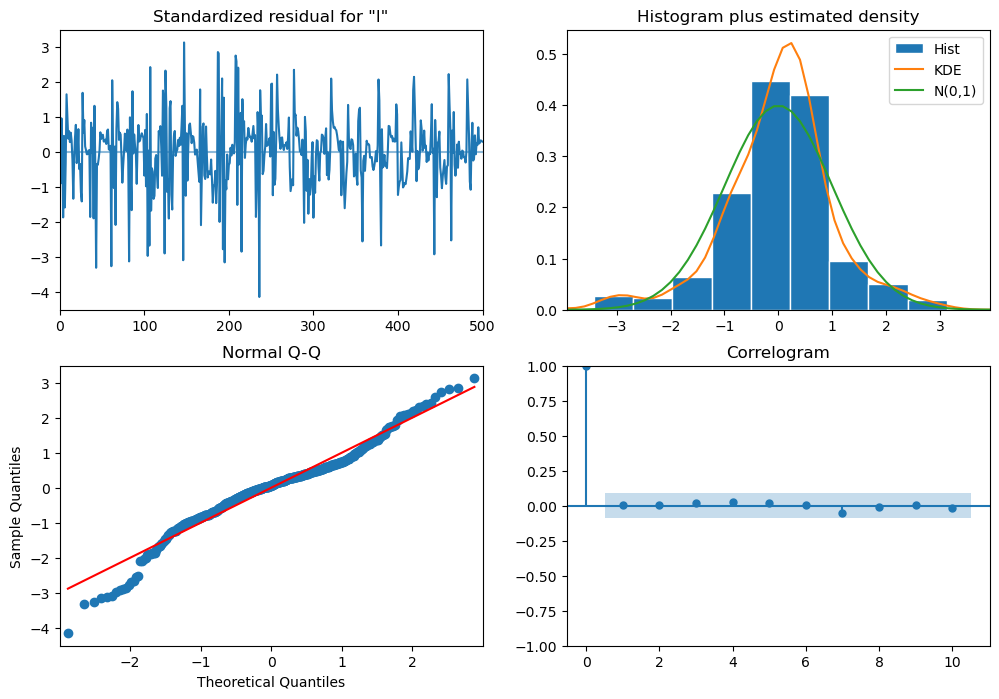

In [21]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Replace 'series' with your time series data (e.g., a Pandas Series)
# Example: series = pd.Series([...])

# Create and fit the ARMA(2,3) model
model = ARIMA(train_df["log returns"], order=(0, 0, 4))  # p=2, d=0 (stationary), q=3
fitted_model = model.fit()

train_df['mean'] = fitted_model.fittedvalues

# Print the summary of the model
print(fitted_model.summary())

plt.figure(figsize=(10, 6))


# Diagnostics plot
fitted_model.plot_diagnostics(figsize=(12, 8))
plt.show()


/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/3526032038.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["residuals"] = list(residuals)


<Figure size 1000x400 with 0 Axes>

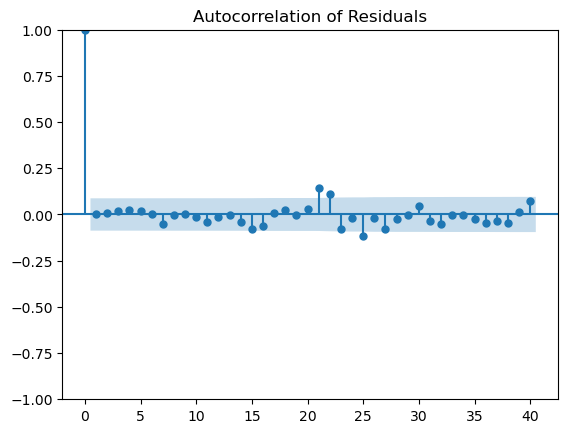

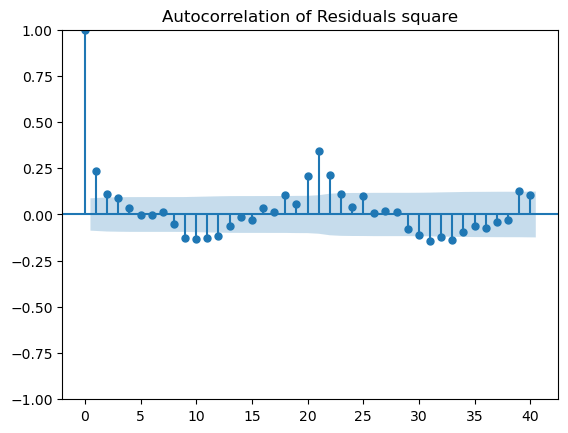

Ljung-Box Test Results:
     lb_stat  lb_pvalue
10  2.171367   0.994850
20  9.807780   0.971525
Lag 1: p-value = 0.9948 -> Fail to reject H₀. Data likely represents white noise.
Lag 2: p-value = 0.9715 -> Fail to reject H₀. Data likely represents white noise.

Engle's ARCH Test Results:
LM Statistic: 42.5207
p-value: 0.0000
F-Statistic: 4.5509
p-value: 0.0000
LM Statistic: 42.5207, p-value: 0.0000 -> Reject H₀. Significant ARCH effects detected (time-varying volatility).




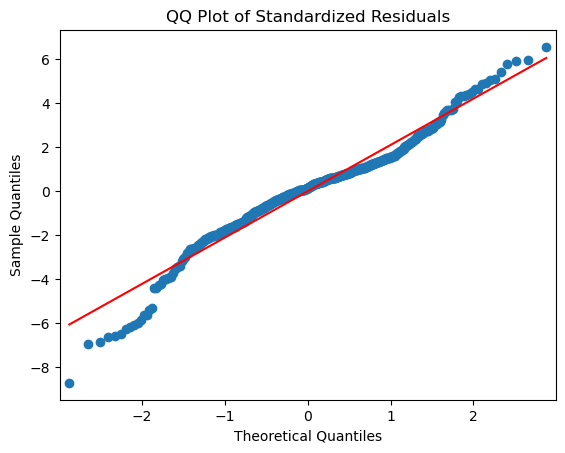



Jarque-Bera Test: JB=88.8794, p-value=0.0000
Residuals do not appear to be normally distributed (reject H0).


In [24]:
residuals = fitted_model.resid
train_df["residuals"] = list(residuals)
resid_df = residuals.reset_index(drop=True).to_frame(name="resid")
resid_df["residSq"] = resid_df["resid"].apply(lambda x: x ** 2)

residual_analysis(resid_df)

## Forecast using ARMA models

In [25]:
n_forecast = len(test_df)
forecast = fitted_model.get_forecast(steps=n_forecast)

# Extract the forecasted mean and confidence intervals
forecast_mean = forecast.predicted_mean

test_df["mean"] = list(forecast_mean)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/2317141958.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["mean"] = list(forecast_mean)


## Arch Model for volitility

<Figure size 1000x400 with 0 Axes>

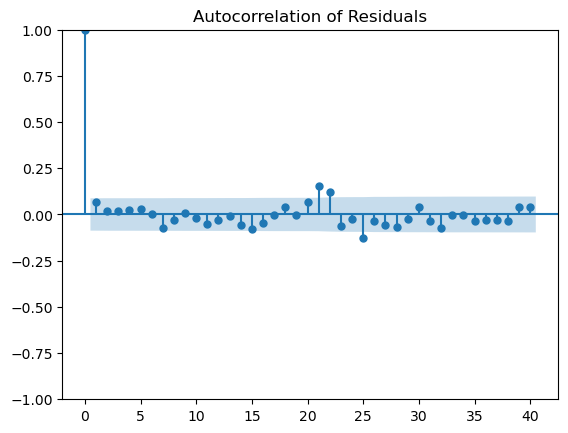

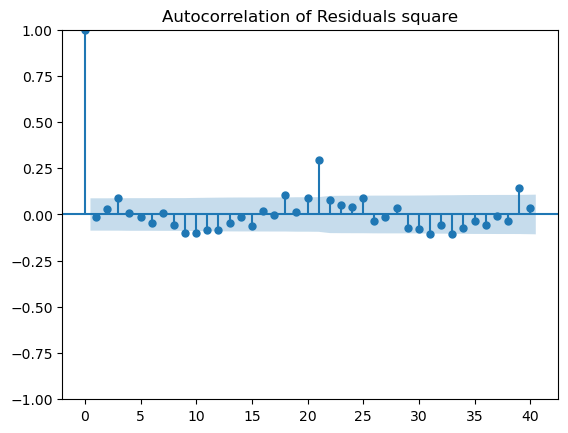

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10   6.455143   0.775686
20  17.550460   0.616995
Lag 1: p-value = 0.7757 -> Fail to reject H₀. Data likely represents white noise.
Lag 2: p-value = 0.6170 -> Fail to reject H₀. Data likely represents white noise.

Engle's ARCH Test Results:
LM Statistic: 16.8119
p-value: 0.0786
F-Statistic: 1.7018
p-value: 0.0775
LM Statistic: 16.8119, p-value: 0.0786 -> Fail to reject H₀. No significant ARCH effects (variance is constant).


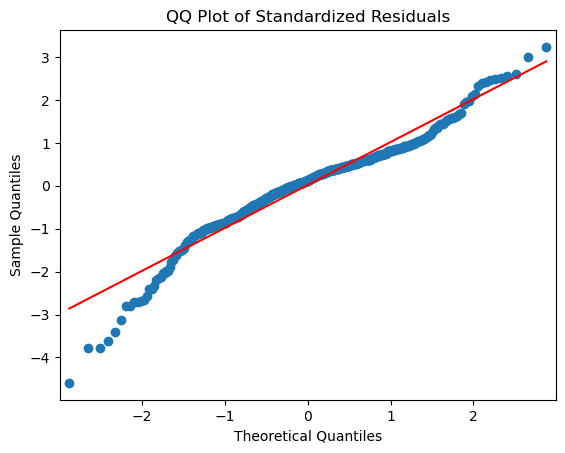



Jarque-Bera Test: JB=174.9410, p-value=0.0000
Residuals do not appear to be normally distributed (reject H0).


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


arch_model_fit = arch_model(train_df["residuals"], vol='ARCH', p=1)  # ARCH(p=1)
arch_result = arch_model_fit.fit(disp="off")

# Extract residuals
standardized_residuals = arch_result.resid / arch_result.conditional_volatility
resid_df = pd.DataFrame()
resid_df["resid"] = list(standardized_residuals)
resid_df["residSq"] = resid_df["resid"].apply(lambda x: x ** 2)

residual_analysis(resid_df)

                      Constant Mean - ARCH Model Results                      
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -1064.75
Distribution:                  Normal   AIC:                           2135.49
Method:            Maximum Likelihood   BIC:                           2148.14
                                        No. Observations:                  501
Date:                Fri, Dec 20 2024   Df Residuals:                      500
Time:                        12:27:44   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0832      0.102     -0.814      0.415 [ -0.283,  0.11

/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/1819456374.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["arch"] = list(arch_result.conditional_volatility.reset_index(drop=True))


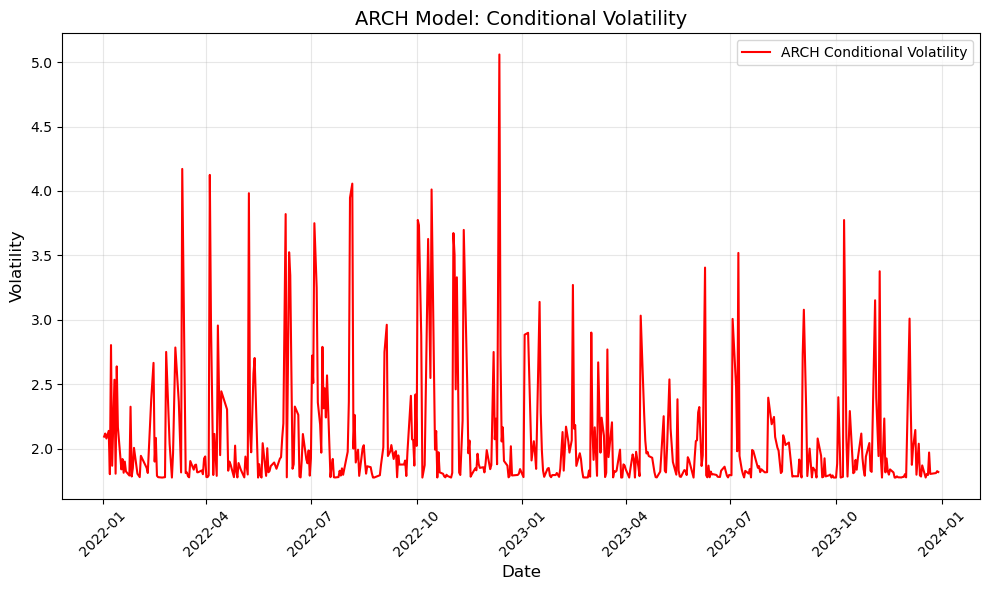

In [27]:
print(arch_result.summary())

# Plot conditional volatility
train_df["arch"] = list(arch_result.conditional_volatility.reset_index(drop=True))
plt.figure(figsize=(10, 6))
plt.plot(train_df["Date"], train_df["arch"], label="ARCH Conditional Volatility", color='red', linestyle='-')  # Line with dots
plt.title("ARCH Model: Conditional Volatility", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volatility", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(alpha=0.3)  # Optional: Add a grid
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

## Garch Model for Volitility

### GARCH Model ###
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1058.25
Distribution:                  Normal   AIC:                           2124.51
Method:            Maximum Likelihood   BIC:                           2141.38
                                        No. Observations:                  501
Date:                Fri, Dec 20 2024   Df Residuals:                      500
Time:                        12:28:14   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0234  8.836e-02     -0.265      0

<Figure size 1000x400 with 0 Axes>

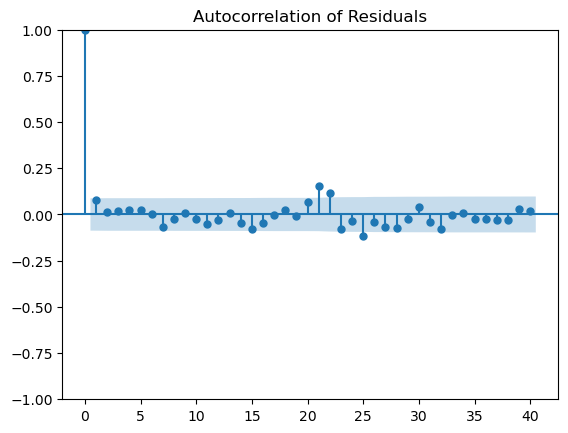

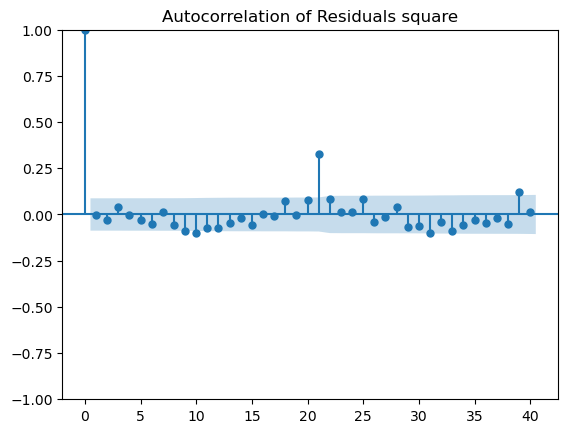

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10   6.823534   0.741993
20  16.634163   0.676585
Lag 1: p-value = 0.7420 -> Fail to reject H₀. Data likely represents white noise.
Lag 2: p-value = 0.6766 -> Fail to reject H₀. Data likely represents white noise.

Engle's ARCH Test Results:
LM Statistic: 13.9281
p-value: 0.1763
F-Statistic: 1.4014
p-value: 0.1763
LM Statistic: 13.9281, p-value: 0.1763 -> Fail to reject H₀. No significant ARCH effects (variance is constant).


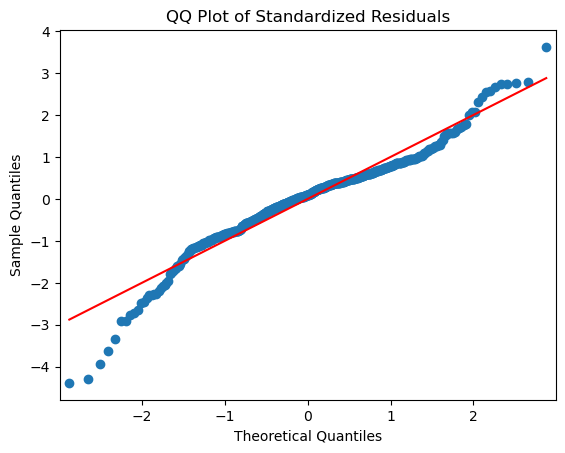



Jarque-Bera Test: JB=182.6817, p-value=0.0000
Residuals do not appear to be normally distributed (reject H0).


In [28]:
print("### GARCH Model ###")
garch_model_fit = arch_model(train_df["residuals"], vol='Garch', p=1, q=1)  # GARCH(1, 1)
garch_result = garch_model_fit.fit(disp="off", cov_type="classic")
print(garch_result.summary())

# Extract residuals
standardized_residuals = garch_result.resid / garch_result.conditional_volatility
resid_df = pd.DataFrame()
resid_df["resid"] = list(standardized_residuals)
resid_df["residSq"] = resid_df["resid"].apply(lambda x: x ** 2)

residual_analysis(resid_df)

## Residuals are not normal, we will use Quassi Maximum likelihood estimators

                     Constant Mean - GARCH Model Results                      
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1058.25
Distribution:                  Normal   AIC:                           2124.51
Method:            Maximum Likelihood   BIC:                           2141.38
                                        No. Observations:                  501
Date:                Fri, Dec 20 2024   Df Residuals:                      500
Time:                        12:29:39   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0.0234      0.110     -0.212      0.832 [ -0.240,  0.19

/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/121520370.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["garch"] = list(garch_result.conditional_volatility.reset_index(drop=True))


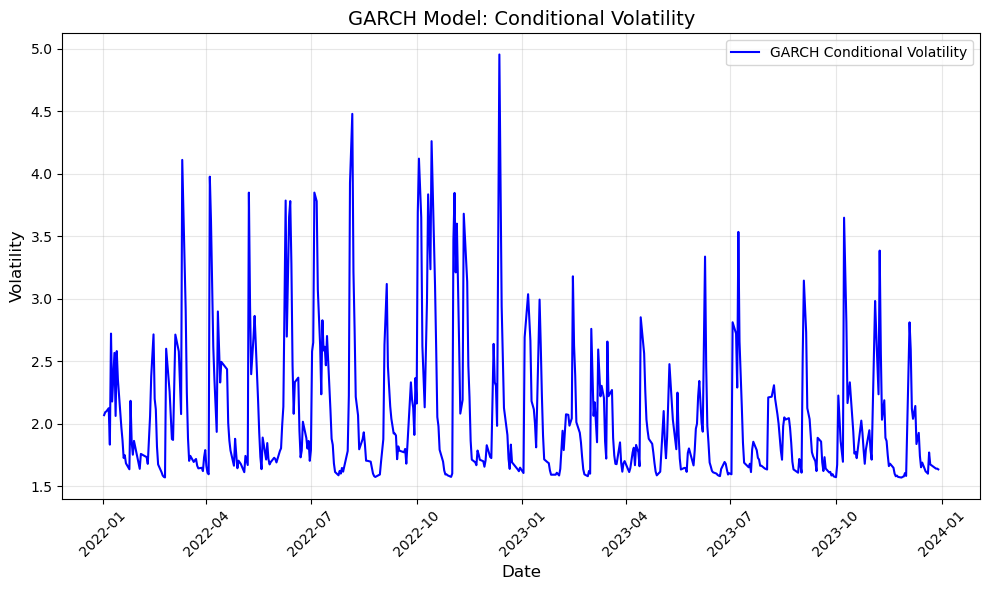

<Figure size 1000x400 with 0 Axes>

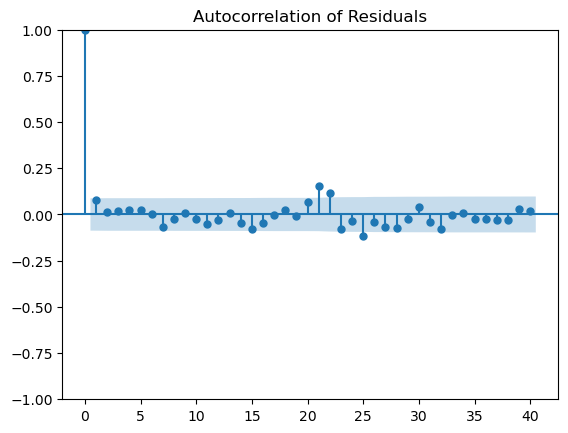

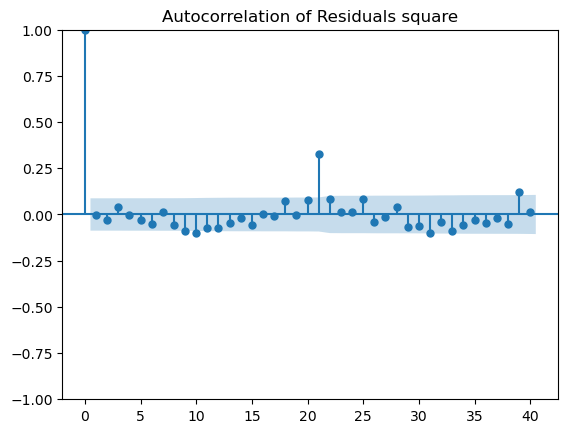

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10   6.823534   0.741993
20  16.634163   0.676585
Lag 1: p-value = 0.7420 -> Fail to reject H₀. Data likely represents white noise.
Lag 2: p-value = 0.6766 -> Fail to reject H₀. Data likely represents white noise.

Engle's ARCH Test Results:
LM Statistic: 13.9281
p-value: 0.1763
F-Statistic: 1.4014
p-value: 0.1763
LM Statistic: 13.9281, p-value: 0.1763 -> Fail to reject H₀. No significant ARCH effects (variance is constant).


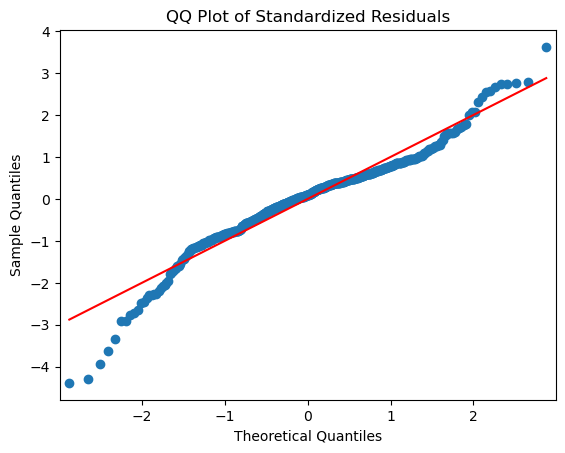



Jarque-Bera Test: JB=182.6817, p-value=0.0000
Residuals do not appear to be normally distributed (reject H0).


In [30]:
garch_model = arch_model(train_df["residuals"], vol="Garch", p=1, q=1, dist="normal")
garch_result = garch_model.fit(update_freq=10, disp="off", cov_type="robust")
print(garch_result.summary())
train_df["garch"] = list(garch_result.conditional_volatility.reset_index(drop=True))
plt.figure(figsize=(10, 6))
plt.plot(train_df["Date"], train_df["garch"], label="GARCH Conditional Volatility", color='blue', linestyle='-')  # Line with dots
plt.title("GARCH Model: Conditional Volatility", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volatility", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(alpha=0.3)  # Optional: Add a grid
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

standardized_residuals = garch_result.resid / garch_result.conditional_volatility
resid_df = pd.DataFrame()
resid_df["resid"] = list(standardized_residuals)
resid_df["residSq"] = resid_df["resid"].apply(lambda x: x ** 2)

residual_analysis(resid_df)

## EGARCH Model for Volitility

### EGARCH Model ###
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1059.24
Distribution:                  Normal   AIC:                           2126.48
Method:            Maximum Likelihood   BIC:                           2143.35
                                        No. Observations:                  501
Date:                Fri, Dec 20 2024   Df Residuals:                      500
Time:                        12:29:56   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0440  1.436e-0

<Figure size 1000x400 with 0 Axes>

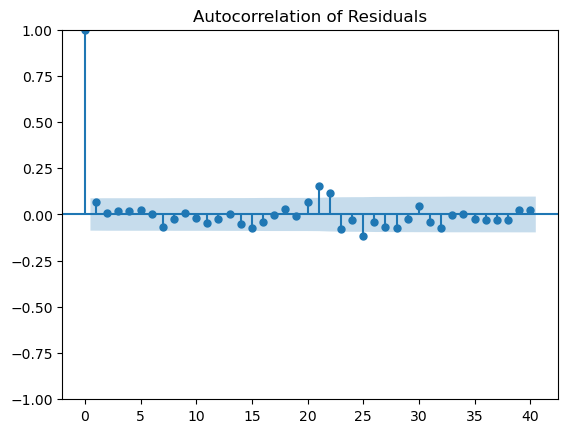

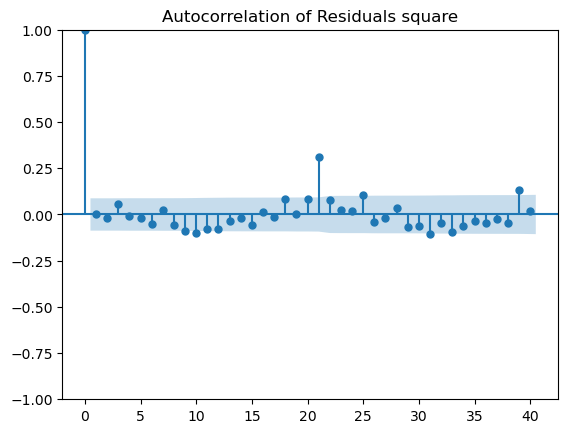

Ljung-Box Test Results:
      lb_stat  lb_pvalue
10   5.684151   0.841065
20  14.853666   0.784719
Lag 1: p-value = 0.8411 -> Fail to reject H₀. Data likely represents white noise.
Lag 2: p-value = 0.7847 -> Fail to reject H₀. Data likely represents white noise.

Engle's ARCH Test Results:
LM Statistic: 14.6183
p-value: 0.1466
F-Statistic: 1.4729
p-value: 0.1462
LM Statistic: 14.6183, p-value: 0.1466 -> Fail to reject H₀. No significant ARCH effects (variance is constant).


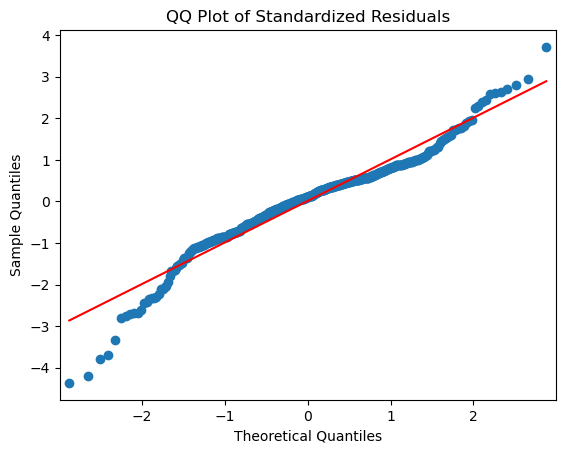



Jarque-Bera Test: JB=176.2699, p-value=0.0000
Residuals do not appear to be normally distributed (reject H0).


In [31]:
print("### EGARCH Model ###")
egarch_model_fit = arch_model(train_df["residuals"], vol='EGarch', p=1, q=1)  # EGARCH(1, 1)
egarch_result = egarch_model_fit.fit(disp="off", cov_type = "classic")
print(egarch_result.summary())

# Extract residuals
standardized_residuals = egarch_result.resid / egarch_result.conditional_volatility
resid_df = pd.DataFrame()
resid_df["resid"] = list(standardized_residuals)
resid_df["residSq"] = resid_df["resid"].apply(lambda x: x ** 2)

residual_analysis(resid_df)

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              residuals   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1059.24
Distribution:                  Normal   AIC:                           2126.48
Method:            Maximum Likelihood   BIC:                           2143.35
                                        No. Observations:                  501
Date:                Fri, Dec 20 2024   Df Residuals:                      500
Time:                        12:30:12   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0.0440  3.037e-03    -14.499  1.222e-

/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/3120567852.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["egarch"] = list(egarch_result.conditional_volatility.reset_index(drop=True))


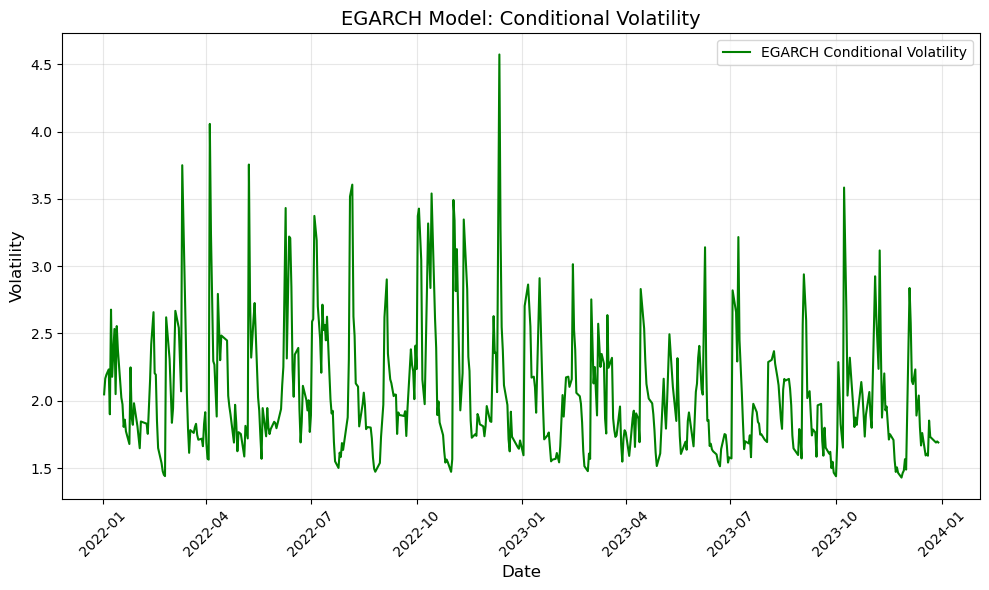

In [32]:
# Plot conditional volatility
egarch_model_fit = arch_model(train_df["residuals"], vol='EGarch', p=1, q=1)
egarch_result = egarch_model_fit.fit(update_freq=10, disp="off", cov_type="robust")
print(egarch_result.summary())

train_df["egarch"] = list(egarch_result.conditional_volatility.reset_index(drop=True))

# Plot with dates on the x-axis
plt.figure(figsize=(10, 6))
plt.plot(train_df["Date"], train_df["egarch"], label="EGARCH Conditional Volatility", color='green', linestyle='-')  # Line with dots
plt.title("EGARCH Model: Conditional Volatility", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volatility", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.grid(alpha=0.3)  # Optional: Add a grid
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/19507109.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Date'] = pd.to_datetime(train_df['Date'])


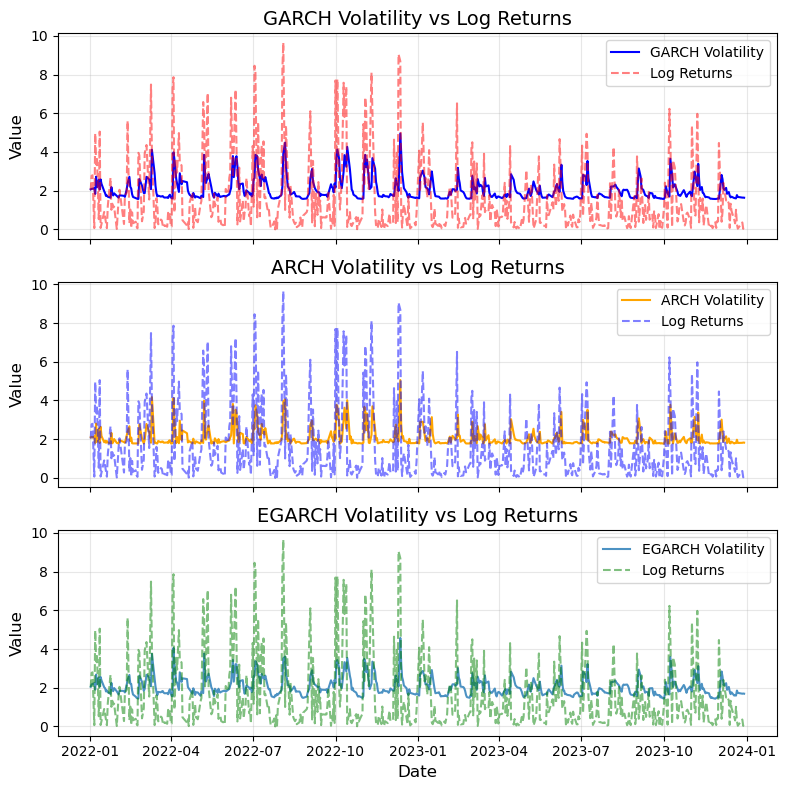

In [50]:
import matplotlib.pyplot as plt

# Ensure the Date column is in datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])

# Set the figure size and grid layout
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

# Plot GARCH vs Log Returns
axes[0].plot(train_df['Date'], train_df['garch'], label='GARCH Volatility', color='blue', linestyle='-')
axes[0].plot(train_df['Date'], train_df['log returns'].apply(lambda x: abs(x)), label='Log Returns', linestyle='--', color='red', alpha=0.5)
axes[0].set_title('GARCH Volatility vs Log Returns', fontsize=14)
axes[0].set_ylabel('Value', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot ARCH vs Log Returns
axes[1].plot(train_df['Date'], train_df['arch'], label='ARCH Volatility', color='orange', linestyle='-')
axes[1].plot(train_df['Date'], train_df['log returns'].apply(lambda x: abs(x)), label='Log Returns', linestyle='--', color='blue', alpha=0.5)
axes[1].set_title('ARCH Volatility vs Log Returns', fontsize=14)
axes[1].set_ylabel('Value', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)

# Plot EGARCH vs Log Returns
axes[2].plot(train_df['Date'], train_df['egarch'], label='EGARCH Volatility' , linestyle='-', alpha=0.8)
axes[2].plot(train_df['Date'], train_df['log returns'].apply(lambda x: abs(x)), label='Log Returns', linestyle='--', color='green', alpha=0.5)
axes[2].set_title('EGARCH Volatility vs Log Returns', fontsize=14)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].set_ylabel('Value', fontsize=12)
axes[2].legend()
axes[2].grid(alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# Garch + ARMA

In [51]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['garch_pred'] = train_df['mean'] + train_df['garch']
train_df['arch_pred'] = train_df['mean'] + train_df['arch']
train_df['egarch_pred'] = train_df['mean'] + train_df['egarch']

# Create a figure with 4 subplots (one for each year)
def get_comparision(train_df, year):
    fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharex=True)
    yearly_data = train_df[train_df['Date'].dt.year == year]

    # Group by month and extract the first entry of each month
    monthly_data = yearly_data.groupby(yearly_data['Date'].dt.to_period('M')).first()
    monthly_data = monthly_data.rename_axis("Month").reset_index()  # Rename the index before resetting
    monthly_data['Month'] = monthly_data['Month'].dt.to_timestamp()  # Convert period to timestamp for plotting
    
    # Generate monthly positions and labels
    monthly_positions = monthly_data['Month']
    monthly_labels = monthly_positions.dt.strftime('%b')  # Format as "Jan", "Feb", etc.

    # Plot Log Returns for the year
    plt.plot(yearly_data['Date'], yearly_data['log returns'].apply(lambda x: abs(x)), 
             label=f'Log Returns ({year})', linestyle='--', color='red', alpha=0.5)
    
    # Plot GARCH Predicted for the year
    plt.plot(yearly_data['Date'], yearly_data['garch_pred'], 
             label=f'GARCH (Mean + Volatility) ({year})', linestyle='-', alpha=0.8)

    # Set the title and labels
    plt.title(f'GARCH (Mean + Volatility) vs Log Returns {year}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    
    # Set x-axis ticks to show only the months
    plt.xticks(monthly_positions, monthly_labels, rotation=45)
    
    # Add a legend
    plt.legend(fontsize=10)
    
    # Add a grid for better visualization
    plt.grid(alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()



/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/3689212130.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Date'] = pd.to_datetime(train_df['Date'])
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/3689212130.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['garch_pred'] = train_df['mean'] + train_df['garch']
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/3689212130.py:6: SettingWithCopyWarning: 
A value is trying to be set on a co

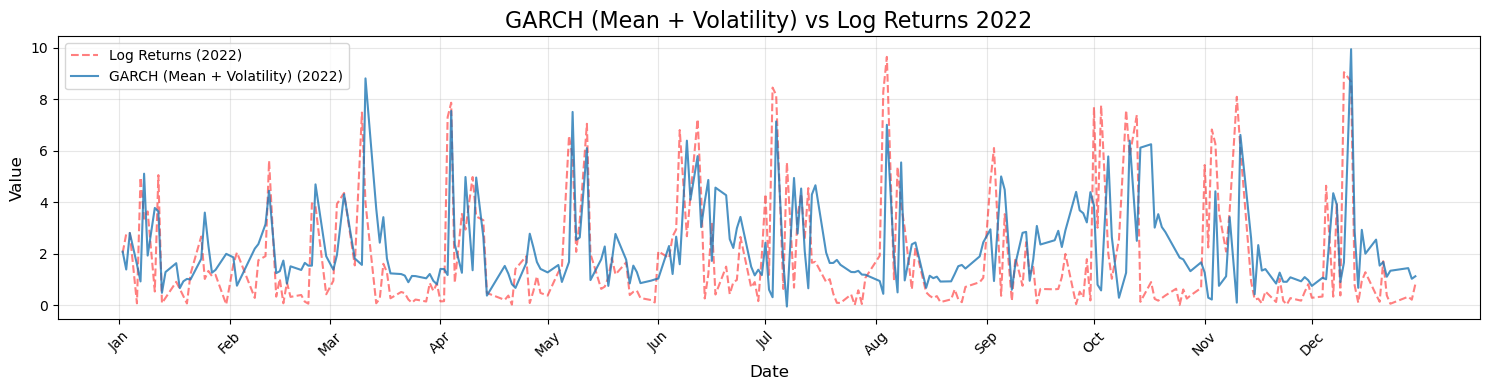

In [52]:
get_comparision(train_df, 2022)

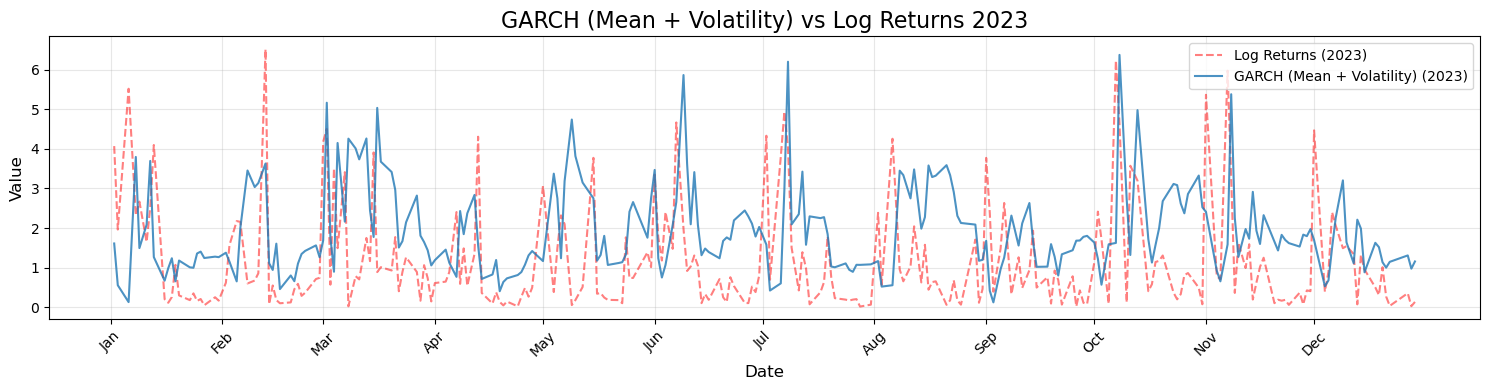

In [53]:
get_comparision(train_df, 2023)

## EGarch + ARMA

In [54]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['garch_pred'] = train_df['mean'] + train_df['garch']
train_df['arch_pred'] = train_df['mean'] + train_df['arch']
train_df['egarch_pred'] = train_df['mean'] + train_df['egarch']

# Create a figure with 4 subplots (one for each year)
def get_comparision(train_df, year):
    fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharex=True)
    yearly_data = train_df[train_df['Date'].dt.year == year]

    # Group by month and extract the first entry of each month
    monthly_data = yearly_data.groupby(yearly_data['Date'].dt.to_period('M')).first()
    monthly_data = monthly_data.rename_axis("Month").reset_index()  # Rename the index before resetting
    monthly_data['Month'] = monthly_data['Month'].dt.to_timestamp()  # Convert period to timestamp for plotting
    
    # Generate monthly positions and labels
    monthly_positions = monthly_data['Month']
    monthly_labels = monthly_positions.dt.strftime('%b')  # Format as "Jan", "Feb", etc.

    # Plot Log Returns for the year
    plt.plot(yearly_data['Date'], yearly_data['log returns'].apply(lambda x: abs(x)), 
             label=f'Log Returns ({year})', linestyle='--', color='red', alpha=0.5)
    
    # Plot GARCH Predicted for the year
    plt.plot(yearly_data['Date'], yearly_data['egarch_pred'], 
             label=f'EGARCH (Mean + Volatility) ({year})', linestyle='-', alpha=0.8)

    # Set the title and labels
    plt.title(f'EGARCH (Mean + Volatility) vs Log Returns {year}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    
    # Set x-axis ticks to show only the months
    plt.xticks(monthly_positions, monthly_labels, rotation=45)
    
    # Add a legend
    plt.legend(fontsize=10)
    
    # Add a grid for better visualization
    plt.grid(alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()



/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/546317549.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Date'] = pd.to_datetime(train_df['Date'])
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/546317549.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['garch_pred'] = train_df['mean'] + train_df['garch']
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/546317549.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy 

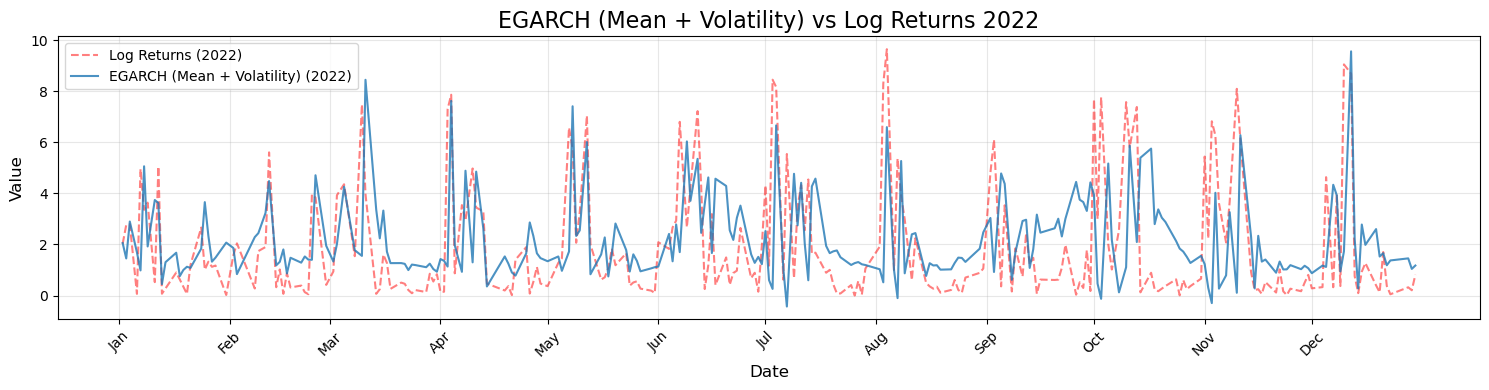

In [55]:
get_comparision(train_df, 2022)

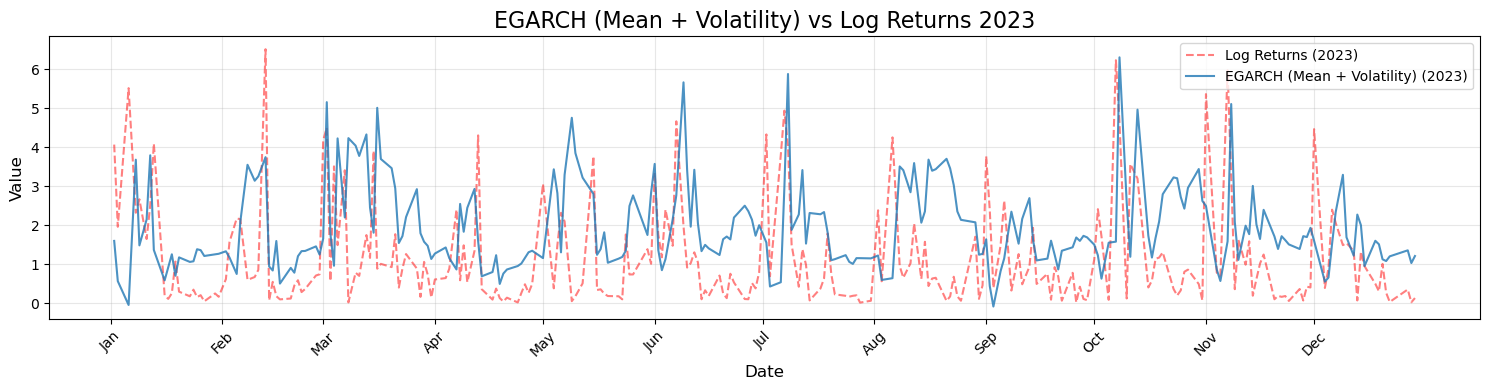

In [56]:
get_comparision(train_df, 2023)

## future forecast of volitility

In [40]:
forecast = egarch_result.forecast(horizon=len(test_df), method="simulation", reindex=False)
simulations = forecast.simulations.values
simulations = np.where(np.isnan(simulations), 0, simulations)  # Replace NaN with 0
simulations = np.maximum(simulations, 0)  # Ensure non-negative values
all_paths_volatility = np.sqrt(simulations)[0] 

In [41]:
all_paths_volatility.shape

(1000, 204)

In [42]:
# GARCH Forecasting
forecast = garch_result.forecast(horizon=len(test_df), method="analytic")
future_volatility_garch = np.sqrt(forecast.variance.values[-len(test_df):].flatten())
test_df["garch"] = future_volatility_garch

# EGARCH Forecasting
forecast = egarch_result.forecast(horizon=len(test_df), method="simulation", reindex=False)
simulations = forecast.simulations.values
simulations = np.where(np.isnan(simulations), 0, simulations)
simulations = np.maximum(simulations, 0)
future_volatility_egarch = np.sqrt(np.nanmean(simulations, axis=(0, 1)))
test_df["egarch"] = future_volatility_egarch





/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/4259708338.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["garch"] = future_volatility_garch
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/4259708338.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["egarch"] = future_volatility_egarch


In [43]:
import matplotlib.pyplot as plt

# Ensure the 'Date' column is in datetime format
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['garch_pred'] = test_df['mean'] + test_df['garch']
test_df['egarch_pred'] = test_df['mean'] + test_df['egarch']

# Create a figure with 4 subplots (one for each year)
def get_comparision(train_df, year, model = "garch_pred"):
    fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharex=True)

    # Plot Log Returns for the year
    plt.plot(train_df['Date'], train_df['log returns'].apply(lambda x: abs(x)), 
             label=f'Log Returns ({year})', linestyle='--', color='red', alpha=0.5)
    
    # Plot GARCH Predicted for the year
    plt.plot(train_df['Date'], train_df[model], 
             label=f'{model} (Mean + Volatility) ({year})', linestyle='-', alpha=0.8)

    # Set the title and labels
    plt.title(f'{model} (Mean + Volatility) vs Log Returns {year}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    
    
    # Add a legend
    plt.legend(fontsize=10)
    
    # Add a grid for better visualization
    plt.grid(alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()



/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/2290855564.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Date'] = pd.to_datetime(test_df['Date'])
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/2290855564.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['garch_pred'] = test_df['mean'] + test_df['garch']
/var/folders/7p/6nnxvlyx16n4w51hy81l24yr0000gq/T/ipykernel_29105/2290855564.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of

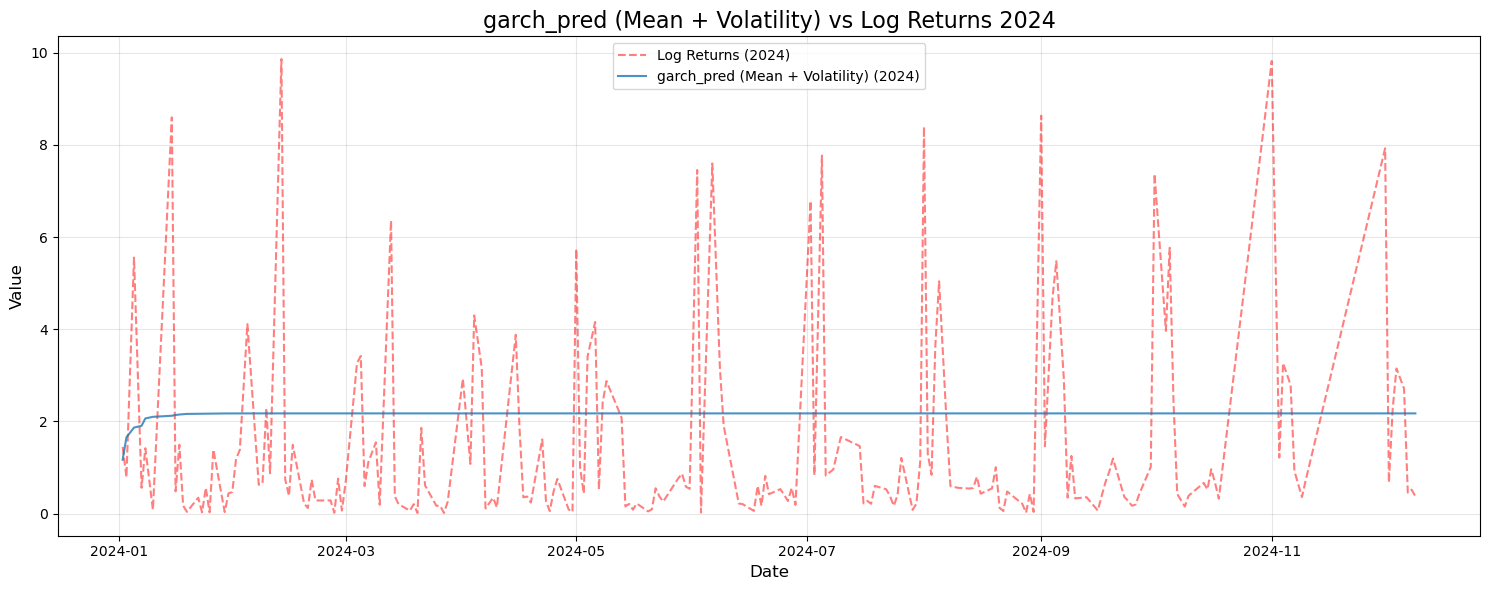

In [44]:
get_comparision(test_df, "2024")

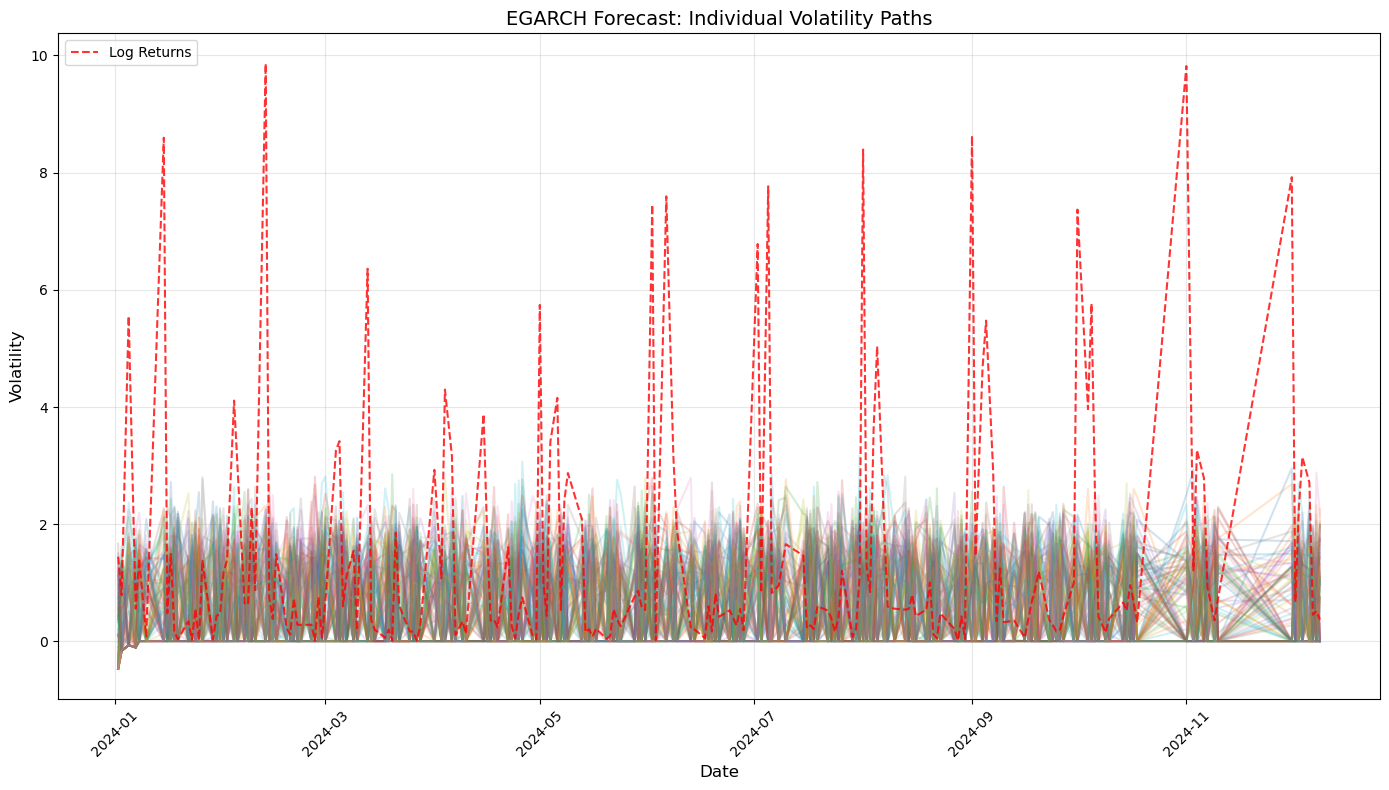

In [45]:
# Extract dimensions of all_paths_volatility
num_paths, horizon = all_paths_volatility.shape


# Plot the first 5 paths
plt.figure(figsize=(14, 8))
for i in range(min(100, num_paths)):  # Limit to the first 5 paths
    vol = list(test_df['mean'] + all_paths_volatility[i, :])
    plt.plot(test_df["Date"], vol, alpha=0.2)

plt.plot(test_df['Date'], test_df['log returns'].apply(lambda x: abs(x)), 
             label=f'Log Returns', linestyle='--', color='red', alpha=0.8)

# Add title and labels
plt.title("EGARCH Forecast: Individual Volatility Paths", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volatility", fontsize=12)
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
